Week 11 · Day 1 — Attention Intuition (Q, K, V)
Why this matters

Attention is the core mechanism behind Transformers (GPT, BERT, etc.). It lets models decide which parts of a sequence matter most, enabling them to scale beyond RNNs. Today you’ll build intuition for queries, keys, and values.

Theory Essentials

Query (Q): what we’re looking for.

Key (K): what each token “offers” for matching.

Value (V): the actual content we’ll mix and pass forward.

Dot-product similarity: compares Q vs K.

Attention weights: softmax of similarities.

Weighted sum: apply weights to values to get the output.

Scores: [[1 0 1]]
Weights: [[0.4223188 0.1553624 0.4223188]]
Attention output: [[ 2. 20.]]


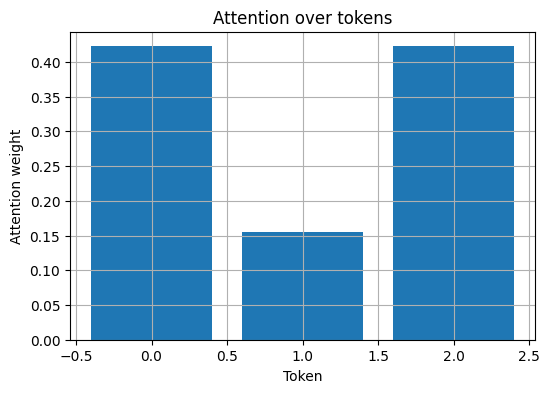

In [1]:
# Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

# --- Toy example: 3 tokens, 2D vectors ---
Q = np.array([[1,0]])      # query
K = np.array([[1,0],[0,1],[1,1]])  # keys
V = np.array([[1,10],[2,20],[3,30]]) # values

# Compute attention weights
scores = Q @ K.T            # dot products
weights = np.exp(scores) / np.exp(scores).sum()

# Weighted sum of values
attn_output = weights @ V

print("Scores:", scores)
print("Weights:", weights)
print("Attention output:", attn_output)

# Plot weights as a bar chart
plt.bar(range(len(weights.flatten())), weights.flatten())
plt.xlabel("Token")
plt.ylabel("Attention weight")
plt.title("Attention over tokens")
plt.show()




## Example: Translating a sentence

Imagine you want to translate **“The cat sat on the mat”** into another language.

* You’re processing the word **“sat.”**
* To decide how to translate it, the model needs to **look back**:

  * “cat” (subject)
  * “mat” (object/place)

Attention helps the model decide:
👉 *“When I translate **‘sat’**, which other words should I pay attention to?”*

---

## Role of Q, K, V

Think of it like a **search engine inside the model**:

* **Query (Q):** The current word asking: *“What do I need?”*
  (e.g., “sat” wants to know its subject and object.)
* **Keys (K):** Labels that each word carries about what it offers.
  (“cat” offers subject info, “mat” offers location info.)
* **Values (V):** The actual content/info of the word.
  (The embeddings — rich vectors that represent meaning.)

The model:

1. Compares **Q** with every **K** → dot product = similarity score.
2. Passes scores through **softmax** → turns them into weights (0–1, sum = 1).
3. Uses weights to mix the **V**s → output is a context-aware embedding.

So for “sat”:

* High weight to **“cat”** (subject).
* Some weight to **“mat”** (object/place).
* Little weight to other words.

---

## What is Softmax?

Softmax is just a mathematical trick to turn numbers into **probabilities**.

Formula:

$$
\text{softmax}(s_i) = \frac{e^{s_i}}{\sum_j e^{s_j}}
$$

Properties:

* Outputs are always between **0 and 1**.
* They **add up to 1** (like probabilities).
* Bigger input → bigger probability, but smoothly scaled.

### Example:

If raw scores = `[2, 1, 0]`

$$
e^2 = 7.39, \quad e^1 = 2.71, \quad e^0 = 1
$$

Sum = 11.1

Softmax = `[0.66, 0.24, 0.09]`

👉 The first item gets most of the focus.

---

## Why is this useful?

Because now each word can dynamically **decide where to look**.

* RNNs only look one step at a time.
* Attention lets you look **everywhere at once**, weighted by importance.

That’s why Transformers scale so well: every token can see **all other tokens** directly.



### Step 1: Query vs Keys → Relevance

* Dot product tells us how much **Q** (what we’re looking for) matches each **K** (what tokens offer).
* Softmax turns those scores into **weights** (probabilities).
* Bigger weight = “this token is more relevant to my query.”

---

### Step 2: Why multiply by Values (V)?

Remember:

* **Keys (K):** only used to measure *relevance*.
* **Values (V):** hold the actual *information* we want to pass forward.

So after softmax, we have weights like:

```
Token 0: 0.7 (important)
Token 1: 0.2
Token 2: 0.1
```

Now, instead of just picking token 0, we make a **weighted average** of their values.

---

### Tiny Example with Numbers

Say we have:

```
V = [[1, 10],   # value for token 0
     [2, 20],   # value for token 1
     [3, 30]]   # value for token 2

Weights = [0.7, 0.2, 0.1]
```

Compute:

$$
\text{Output} = 0.7*[1,10] + 0.2*[2,20] + 0.1*[3,30]
$$

\= `[0.7*1 + 0.2*2 + 0.1*3, 0.7*10 + 0.2*20 + 0.1*30]`
\= `[1.6, 14.0]`

---

### Why this?

Because the output should represent **a mix of the most relevant tokens’ information**.

👉 In words:

* The query looked at all tokens.
* It decided token 0 mattered most, but tokens 1 and 2 still add a little.
* The output is a **blended representation** based on those relevance scores.

This blended vector goes forward in the network — now “aware” of the context.



1) Core (10–15 min)
Task: Change the query vector to [0,1] and rerun. Which token gets the most weight?

In [3]:
Q = np.array([[0,1]])
scores = Q @ K.T
weights = np.exp(scores) / np.exp(scores).sum()
print(weights)


[[0.1553624 0.4223188 0.4223188]]


2) Practice (10–15 min)
Task: Try 2 queries: [1,1] and [2,0]. Compare how weights shift.

In [4]:
for q in [[1,1],[2,0]]:
    Q = np.array([q])
    scores = Q @ K.T
    weights = np.exp(scores)/np.exp(scores).sum()
    print(f"Q={q}, Weights={weights}")


Q=[1, 1], Weights=[[0.21194156 0.21194156 0.57611688]]
Q=[2, 0], Weights=[[0.46831053 0.06337894 0.46831053]]


3) Stretch (optional, 10–15 min)
Task: Add a temperature parameter τ to scale scores before softmax. Try τ = 0.5 and τ = 2.
Hint: Lower τ → sharper focus.

In [7]:
Q = np.array([[1,0]])      # query
K = np.array([[1,0],[0,1],[1,1]])  # keys
V = np.array([[1,10],[2,20],[3,30]]) # values

tau_values = [0.5, 2.0]
for tau in tau_values:
    scores = (Q @ K.T)/tau
    weights = np.exp(scores)/np.exp(scores).sum()
    print(f"tau={tau}, Weights={weights}")


tau=0.5, Weights=[[0.46831053 0.06337894 0.46831053]]
tau=2.0, Weights=[[0.38365173 0.23269654 0.38365173]]


Mini-Challenge (≤40 min)

Build: A small “attention explorer.” Given any query [q1,q2], compute attention over the 3 tokens and plot the bar chart.
Acceptance Criteria:

Input: query vector from user.

Output: printed weights + bar plot.

Clear visual showing which token is attended most.

Scores: [[1 2 3]]
Weights: [[0.09003057 0.24472847 0.66524096]]
Attention output: [[ 2.57521038 25.75210383]]


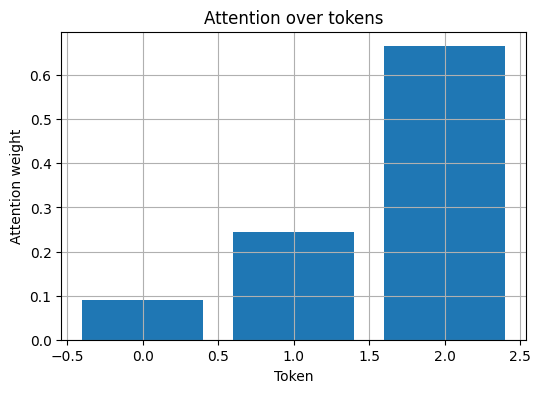

In [8]:

first = int(input("Write the first int of your query: "))
second = int(input("Write the second int of your query: "))

Q = np.array([[first,second]])      # query
K = np.array([[1,0],[0,1],[1,1]])  # keys
V = np.array([[1,10],[2,20],[3,30]]) # values

# Compute attention weights
scores = Q @ K.T            # dot products
weights = np.exp(scores) / np.exp(scores).sum()

# Weighted sum of values
attn_output = weights @ V

print("Scores:", scores)
print("Weights:", weights)
print("Attention output:", attn_output)

# Plot weights as a bar chart
plt.bar(range(len(weights.flatten())), weights.flatten())
plt.xlabel("Token")
plt.ylabel("Attention weight")
plt.title("Attention over tokens")
plt.show()


Notes / Key Takeaways

Attention = weighted average of values.

Weights come from similarity (Q·K).

Queries decide what to look for.

Keys represent token identity/features.

Values are the information carried forward.

Softmax ensures weights sum to 1.

Temperature adjusts focus sharpness.

Reflection

Can you explain the roles of Q, K, and V in one sentence each?

How is attention more flexible than fixed context windows in RNNs?

Q (Query): Represents what the current token is looking for in other tokens.

K (Key): Represents what each token offers for matching.

V (Value): Contains the actual information to be combined based on relevance.

👉 Attention is more flexible than RNNs because it lets each token look at all other tokens in the sequence at once, instead of being limited to a fixed step-by-step context window.